In [ ]:
pip install PyPortfolioOpt

In [ ]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
prices = pd.read_csv("/content/price_data_latest.csv", parse_dates=["Date"],dayfirst=True, index_col="Date")
# The prices CSV should have a column for each asset. Expected assets: ACWX, AGG, BNDX, TLT, ^GSPC


market_cap = pd.read_csv("/content/market_cap_data_latest.csv")
# Assume market_cap CSV has two columns: "Asset" and "MarketCap"
# Set the asset names as index for convenience
market_cap.set_index("Asset", inplace=True)
mcaps = market_cap["MarketCap"].to_dict()

## Constructing the prior

In [ ]:
import pypfopt
pypfopt.__version__

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

# Annualized covariance matrix (252 trading days)
S = risk_models.sample_cov(prices, frequency=252)

delta = 2.5


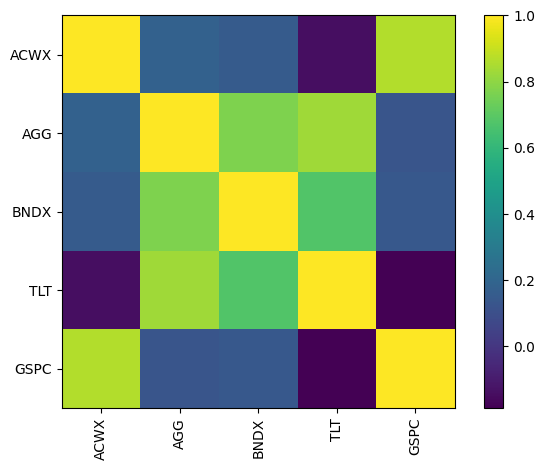

In [ ]:
plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

,0
ACWX,0.032483
AGG,0.005266
BNDX,0.003965
TLT,0.004298
GSPC,0.032812


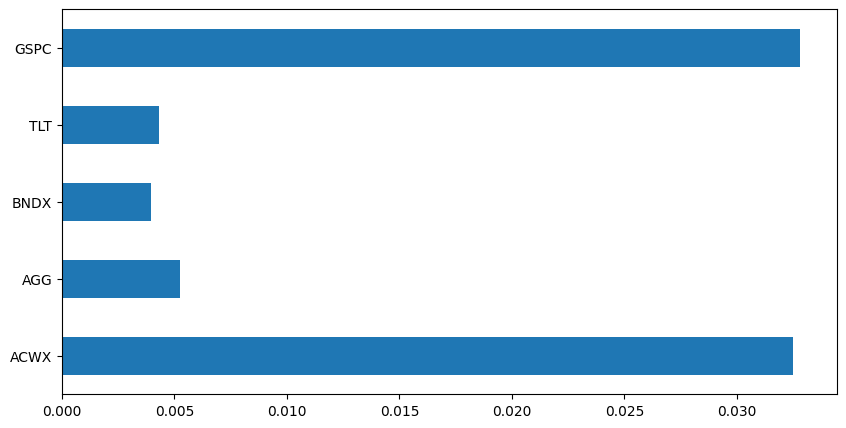

In [ ]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [ ]:
# ----------------------------
# 3. Formulate Absolute Views from Historical Data
# ----------------------------

# Define the historical period to compute views (Jan 2017 to Jan 2021)
view_start = "01-01-2017"
view_end = "01-01-2021"
views_data = prices.loc[view_start:view_end]

# Compute daily returns for the view period and then the mean daily return per asset
views_returns_daily = views_data.pct_change().dropna()
views_mean_daily = views_returns_daily.mean()

# Annualize the mean daily returns: these become our absolute views for expected returns
views_annual = views_mean_daily * 252

# Construct a dictionary of views: keys are asset names and values are the annualized expected returns
viewdict = views_annual.to_dict()
n = len(views_returns_daily)
views_std_daily = views_returns_daily.std()
views_se_daily = views_std_daily / np.sqrt(n)
views_se_annual = views_se_daily * np.sqrt(252)

In [ ]:
viewdict

{'ACWX': 0.11178347413597309,
 'AGG': 0.04893305000118598,
 'BNDX': 0.04458828079633832,
 'TLT': 0.10158046411166091,
 'GSPC': 0.14866395976881872}

In [ ]:
#viewdict_fin = {ticker: annualized_returns_dict[ticker] for ticker in viewdict}

# Now pass this into the Black-Litterman model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

print("Views:", viewdict)

Views: {'ACWX': 0.11178347413597309, 'AGG': 0.04893305000118598, 'BNDX': 0.04458828079633832, 'TLT': 0.10158046411166091, 'GSPC': 0.14866395976881872}


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [ ]:
confidences = [
    0.7,#GSPC
    0.15,#TLT
    0.2,#BNDX
    0.15,#AGG
    0.7 #ACWX
]

In [ ]:
delta = 2.5

In [ ]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

,0
ACWX,0.106703
AGG,0.023817
BNDX,0.018101
TLT,0.030844
GSPC,0.118122


We can visualise how this compares to the prior and our views:

In [ ]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
ACWX,0.032483,0.106703,0.111783
AGG,0.005266,0.023817,0.048933
BNDX,0.003965,0.018101,0.044588
TLT,0.004298,0.030844,0.101580
GSPC,0.032812,0.118122,0.148664


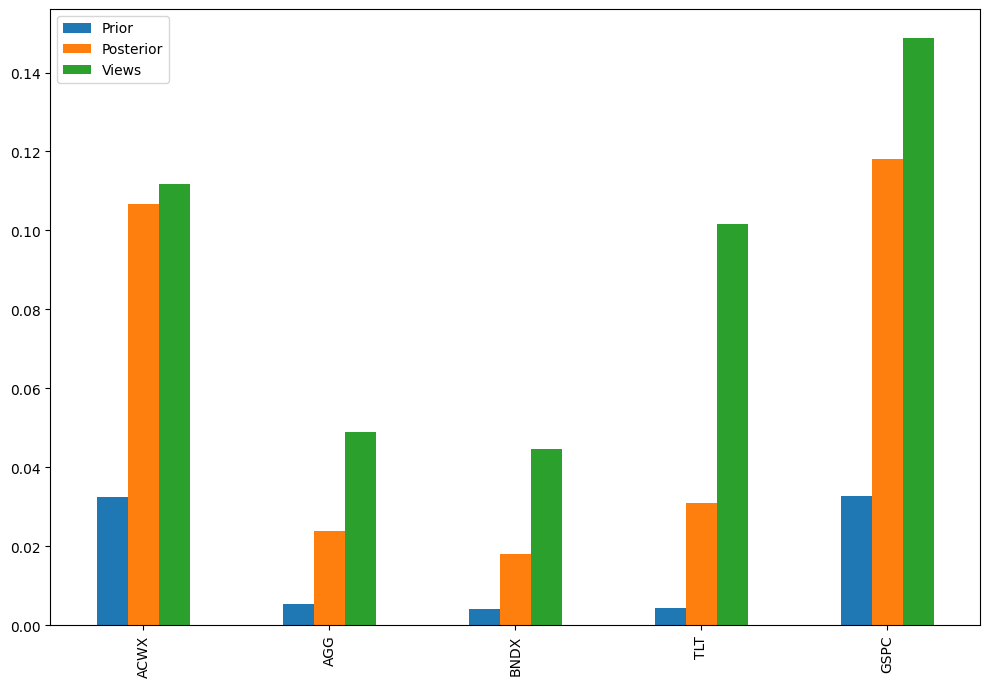

In [ ]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

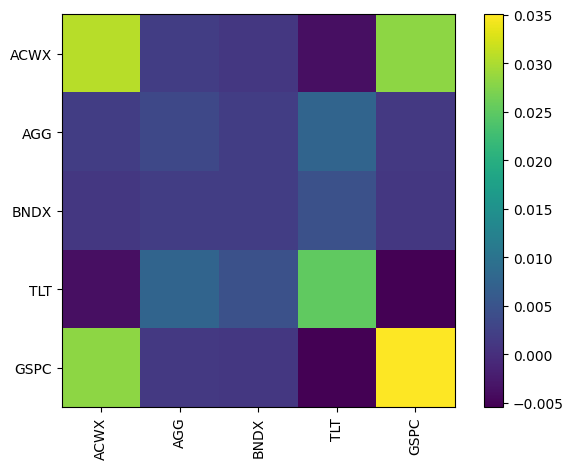

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('ACWX', 0.35444),
             ('AGG', 0.08159),
             ('BNDX', 0.06221),
             ('TLT', 0.10862),
             ('GSPC', 0.39313)])

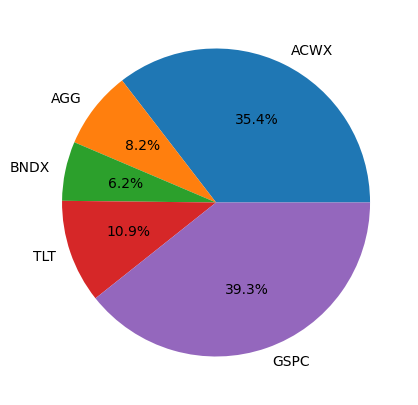

In [30]:
pd.Series(weights).plot.pie(figsize=(5,5,),autopct='%1.1f%%');